In [1]:
# ПОДКЛЮЧЕНИЕ БИБЛИОТЕК
import os
import requests
from tqdm import tqdm
import zipfile
import datetime
import hashlib
from base64 import b64encode

import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from scipy.stats import mannwhitneyu, ttest_ind, kstest, uniform, norm

sns.set_theme()

seed = 111

In [2]:
# ФУНКЦИИ

# Отрисовка гистрограммы распределения p-values
def plot_pvalues_hist(pvalues):
    plt.figure(figsize=(6, 4))
    n = int(1 + np.log2(len(pvalues)) // 1)
    plt.hist(pvalues, bins=n, color='orange')
    plt.show()


# Функции для бутстрепа
def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))


def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result

def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

# Подсчет MDE
def get_mde(metric_vec, alpha=0.05, beta=0.2):

    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()

    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)

    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)

    return mde*100/metric_mean

# Данные: датасет КИОН
- **просмотры** фильмов и сериалов в приложении KION
- данные о пользователях
- данные об айтемах (фильмы, сериалы и т.д.)

##### Загрузка данных

In [ ]:
# Загрузка датасета по чанкам
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:  56%|█████▌    | 44.0M/78.8M [00:39<00:38, 914kiB/s]

In [9]:
# Распаковываем архив из 3 файлов

with zipfile.ZipFile('./data/data_kion.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')

In [3]:
# Чтение данных
interactions = pd.read_csv('./data/data_kion/interactions_df.csv')
users = pd.read_csv('./data/data_kion/users.csv')
items = pd.read_csv('./data/data_kion/items.csv')

# Первичные преобразования
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).map(lambda x: x.date())
interactions['user_id'] = interactions['user_id'].astype(str)
users['user_id'] = users['user_id'].astype(str)

#####  Анализ данных

In [4]:
interactions.head(5)

# user_id - уникальный идентификатор пользователя
# item_id - уникальный идентификатор контента
# last_watch_dt - последняя дата просмотра юзером определенного контента
# total_dur - суммарная продолжительность просмотра определенного контента юзером (в секундах)
# watched_pct - процент просмотренного контента от общей продолжительности

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [5]:
interactions.shape

(5476251, 5)

In [6]:
users.head()

# user_id - уникальный идентификатор пользователя
# kids_flg = 0 - детей нет, если 1 - дети есть
# income - группа, в которую юзер отнесен по доходу
# age - группа, в которую юзер отнесен по возрасту
# sex - пол

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [7]:
users.shape

(840197, 5)

In [8]:
items.head(5)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


In [9]:
items.shape

(15963, 14)

📝 Замечание \
В данных присутствует ошибка. Количество уникальных айтемов и юзеров в таблице interactions не может быть больше количества уникальных айтемов и юзеров в таблицах items и users соответственно. Однако видно, что в таблице interactions это условие для юзеров нарушается.

In [10]:
print(f"Всего уникальных юзеров: {users['user_id'].nunique():_}")
print(f"Всего уникальных айтемов: {items['item_id'].nunique():_}")
print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique():_}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique():_}")

Всего уникальных юзеров: 840_197
Всего уникальных айтемов: 15_963
Уникальных юзеров в interactions: 962_179
Уникальных айтемов в interactions: 15_706


# Подготовка к дизайн A/B

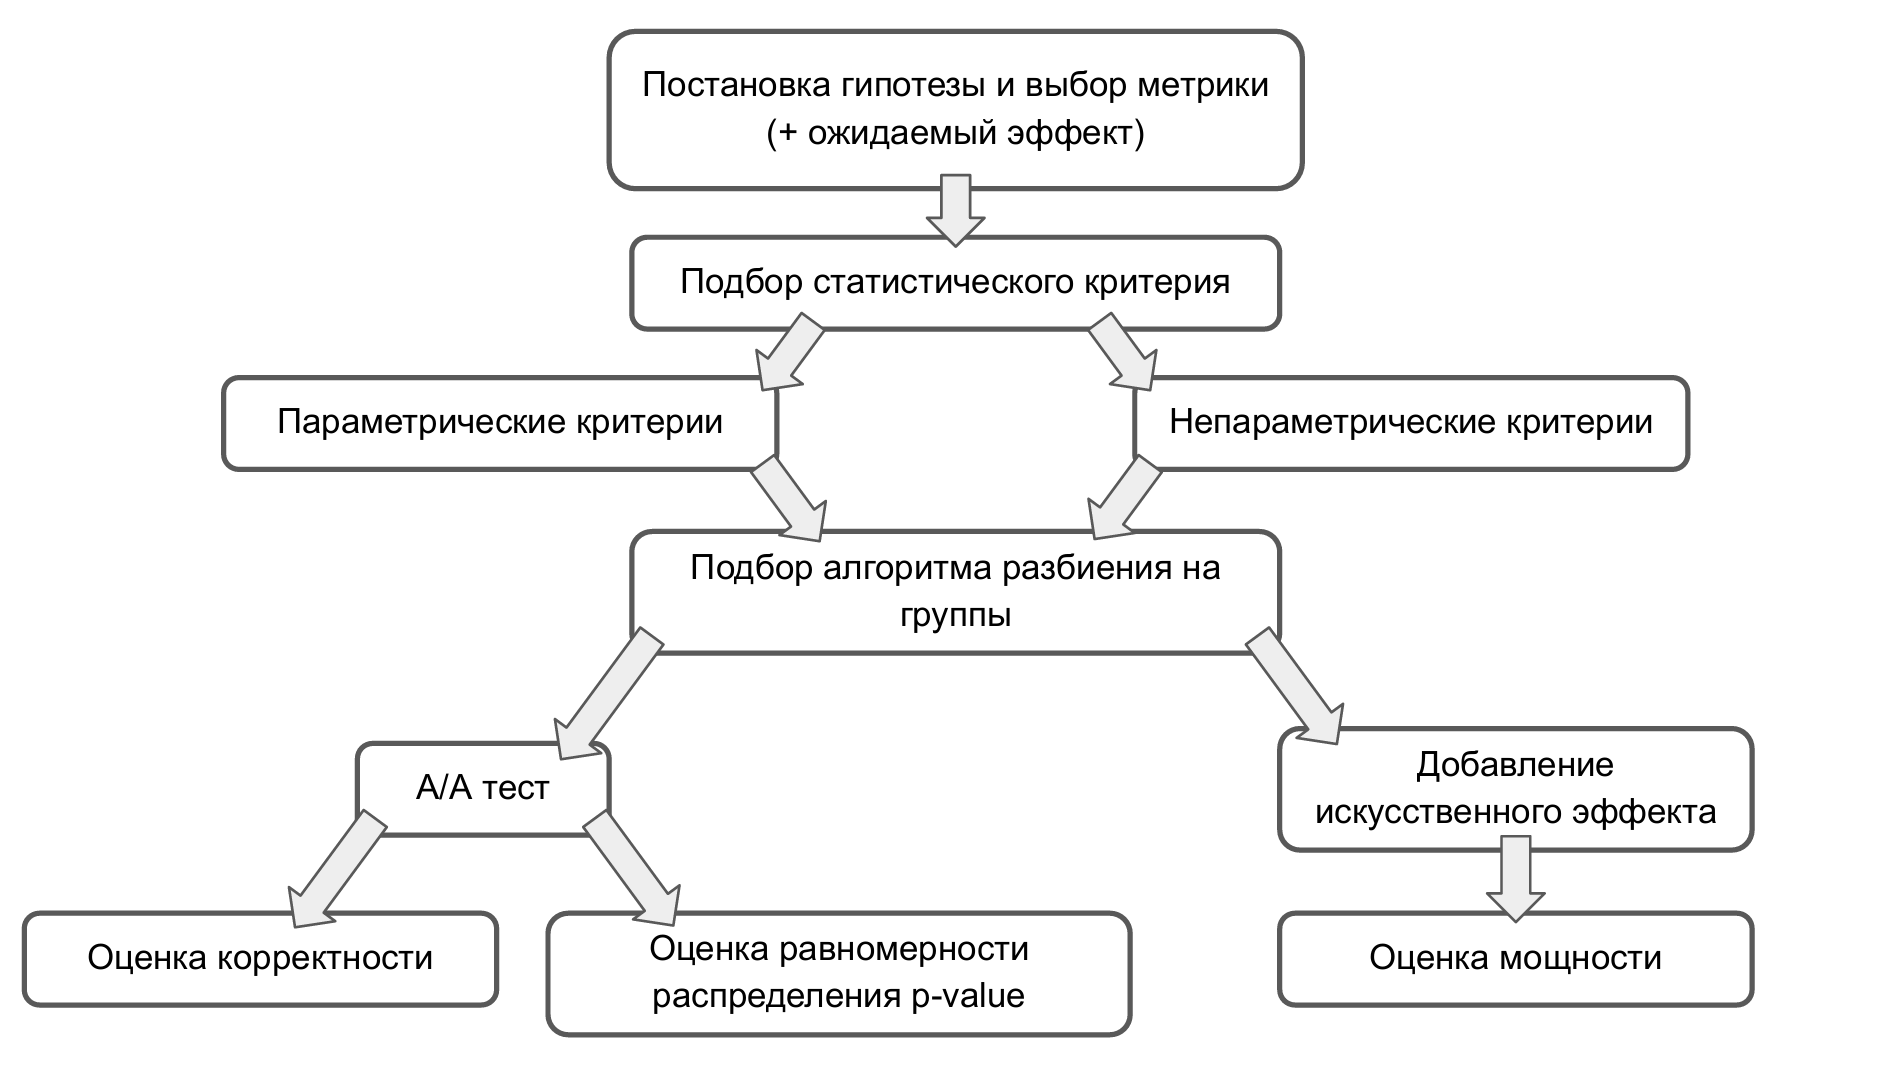

В этой работе следующий пайплайн:
- Выбор метрики и преобразования + эффект
- Выбор данных + препроцессинг + разбиение
- Выбор критерия
- Оценка корректности: посчитать корректность и сравнить с результатами за 1 неделю
- Оценка мощности: добавить эффект в 1%, 3% и 5% и сравните полученную мощность
- Оценка MDE

##### Выбор метрики

Хотим использовать метрику длину просмотра на пользователя (total_dur в датасете) - так как это основная метрика, на которую смотрит бизнес. Поэтому сакцентируем внимание на данных взаимодействий (interactions) и метрике TVTu.


**Преобразование Бокса-Кокса** 

В реальности часто приходится иметь дело со статистическими данными, которые по тем или иным причинам не проходят тест на нормальность. В этой ситуации есть два выхода:
<ul>
    <li>обратиться к непараметрическим методам</li>
    <li>воспользоваться специальными методами, позволяющими преобразовать исходную «ненормальную статистику» в «нормальную»</li>
</ul>
Среди множества таких методов преобразований одним из лучших (при неизвестном типе распределения) считается преобразование Бокса-Кокса.

##### Выбор эффекта 

В рассматриваемых дизайнах будет рассматриваться эффект в 1%, 3% и 5% как разница между группами.

##### Выбор данных

Для дизайна теста и самого A/B-теста могут оказаться важными следующие моменты:
- Продолжительность теста: определяет кол-во данных, а также гарантирует возможность обнаружить эффект
- Рандомные или стратифицированные выборки: на дизайне и тесте формируемые две выборки должны обладать примерно одинаковой энтропией.

📝 Период данных \
Данные получены с 13 марта по 22 августа (меньше года)

In [11]:
# Оценка, за какой период получены данные
max_date = interactions['last_watch_dt'].max()
min_date = interactions['last_watch_dt'].min()
print(min_date, max_date)

2021-03-13 2021-08-22


📝 Визуализация метрики за весь период \
По графику видно увеличение метрики в летний период. Это связано с временем каникул или отпусков.

C:\Users\kshch\AppData\Local\Temp\ipykernel_12268\3330461411.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ax = interactions.groupby('last_watch_dt').agg({'total_dur': sum}).plot(rot=90, x_compat=True, figsize=(10 ,7))


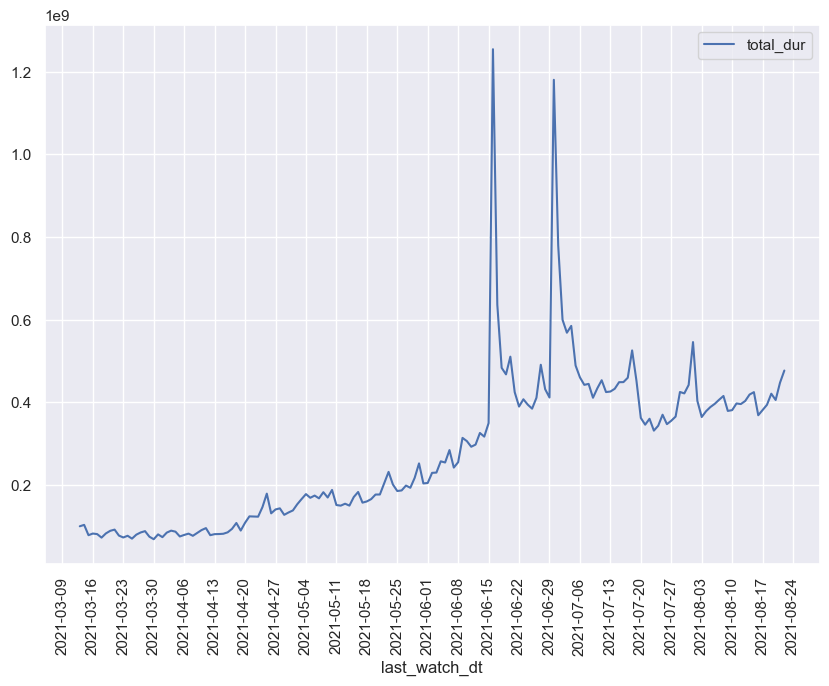

In [12]:
# Визуализация зависимости метрики от времени
ax = interactions.groupby('last_watch_dt').agg({'total_dur': sum}).plot(rot=90, x_compat=True, figsize=(10 ,7))
ax.xaxis.set_major_locator(mdates.WeekdayLocator())

Рассмотрим последний месяц, когда метрика стабилизируется

📝 Визуализация метрики за последний месяц \
Присутствует недельная сезонность. Сезонность позволяет ограничить длительность теста.

C:\Users\kshch\AppData\Local\Temp\ipykernel_12268\1790104849.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  ax = interactions_month.groupby('last_watch_dt').agg({'total_dur': sum}).plot(rot=90, x_compat=True, figsize=(10 ,7))


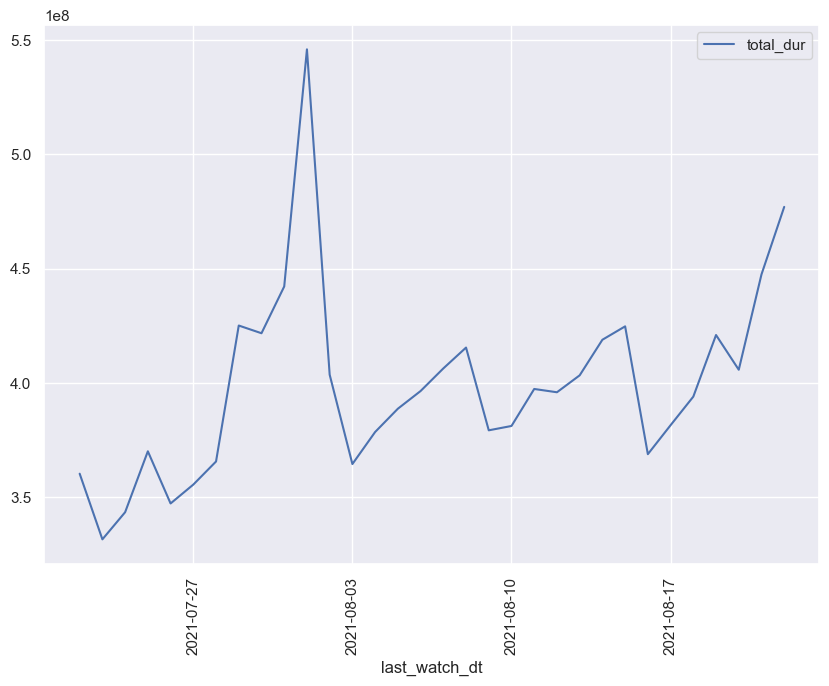

In [13]:
# Выделим данные за последний месяц
interactions_month = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=31)]
ax = interactions_month.groupby('last_watch_dt').agg({'total_dur': sum}).plot(rot=90, x_compat=True, figsize=(10 ,7))
ax.xaxis.set_major_locator(mdates.WeekdayLocator())

Для A/B-теста оставим 2 последние недели (2021-08-09 по 2021-08-22):

In [14]:
# Выделим данные за две последние недели
interactions_2week = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=13)]

In [15]:
interactions_2week.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
6,1016458,354,2021-08-14,1672,25.0
9,203219,13582,2021-08-22,6975,100.0
22,505244,15297,2021-08-15,15991,63.0
24,916352,12846,2021-08-12,1812,30.0
30,1057871,6208,2021-08-12,5033,95.0


In [16]:
interactions_2week.shape

(827089, 5)

In [17]:
# Оценка, за какой период получены данные
print(interactions_2week['last_watch_dt'].min())
print(interactions_2week['last_watch_dt'].max())

2021-08-09
2021-08-22


За этот период провзаимодействовало с сервисом в 3-4 раза меньше уникальных пользователей, чем за весь период.

In [18]:
interactions_2week['user_id'].nunique()

266081

In [19]:
# Значение метрик за выбранный период
users_total_dur = interactions_2week.groupby('user_id', as_index=False).agg({'total_dur': sum})
users_total_dur.head()


C:\Users\kshch\AppData\Local\Temp\ipykernel_12268\1753409888.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  users_total_dur = interactions_2week.groupby('user_id', as_index=False).agg({'total_dur': sum})


,user_id,total_dur
0,1,21172
1,1000,10744
2,1000000,32990
3,1000001,52
4,1000003,625


##### Предобработка и анализ данных

📝 Удаление выбросов \
Удалим выбросы методом межквартильного расстояния

<Axes: >

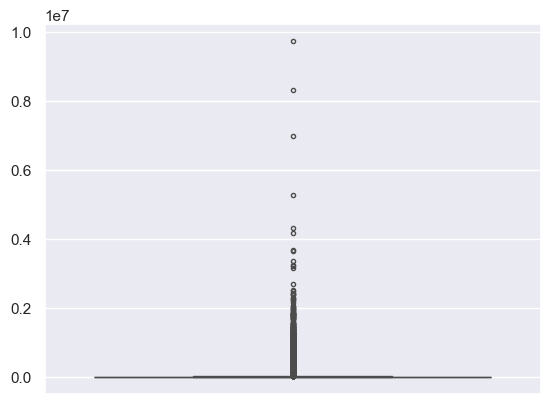

In [20]:
sns.boxplot(users_total_dur['total_dur'].values, fliersize=3)

In [21]:
# Определение границ для метода межквартильного расстояния
x25 = users_total_dur['total_dur'].quantile(q=0.25)
x75 = users_total_dur['total_dur'].quantile(q=0.75)
left = x25 - 1.5 * (x75 - x25)
right = x75 + 1.5 * (x75 - x25)

In [22]:
# Удаление выбросов
print(users_total_dur.shape)
users_total_dur = users_total_dur[(users_total_dur['total_dur'] >= left) & ((users_total_dur['total_dur'] <= right))]
print(users_total_dur.shape)

(266081, 2)
(237706, 2)


<Axes: >

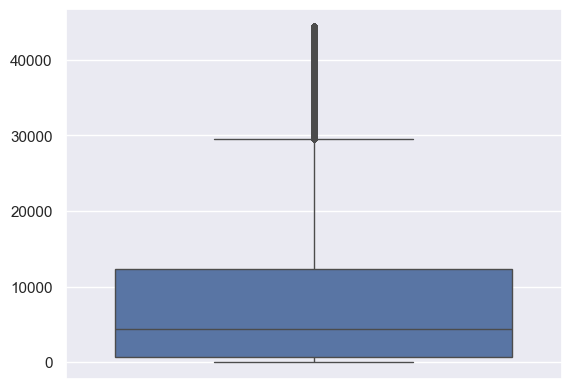

In [23]:
sns.boxplot(users_total_dur['total_dur'].values, fliersize=3)

📝 Визуализация распределения
<p>Используем правило Стёрджеса для определения кол-во интервалов. Распределение ненормальное. Значит, что самые популярные критерии (t-test, z-test) для нашей метрики "длина просмотра" не подойдут, так как они требуют условия на нормальность распределения.</p> 
<p>
Хотя t-test и z-test предполагает нормальное распределение данных, они также являются достаточно робастными к отклонениям от нормальности, особенно при больших размерах выборок. Если наши выборки действительно большие, то центральная предельная теорема может помочь сделать распределение выборочных средних более нормальным, что позволяет использовать t-test и z-test.<p>

<Axes: >

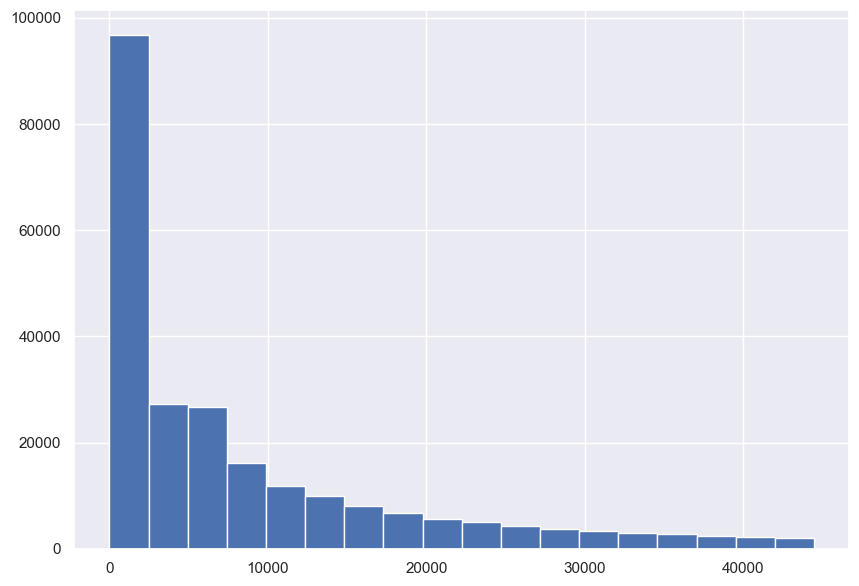

In [114]:
n = int(1 + np.log2(users_total_dur['total_dur'].shape[0]) // 1)
users_total_dur['total_dur'].hist(bins=n, figsize=(10 ,7))

##### Разбиение на группы

Возможные способы:
- рандомное разбиение (при большой выборке)
- стратифицированное разбиение (при малых выборках)

📝 Рандомное разбиение \
Размер таблицы users_total_dur >> 1000, что позволяет разбить данные на группы рандомным образом. 
Рандомное разбиение можно реализовать двумя способами:
<ul>
    <li>Соль + хеширование: позволяет воспроизвести разбиение</li>
    <li>Разбиение с перемешиванием: невозможно воспроизвести</li>
</ul>
Оценим визуально распределения формируемых выборок

* Соль + хеширование

In [71]:
# Генерация соли
def salt_generator(salt=None):
    # os.urandom() method is used to generate a string of size random bytes suitable for cryptographic use
    # or we can say this method generates a string containing random characters.
    salt = os.urandom(8)

    # b64encode - кодирует байтоподобный объект с помощью Base64 и возвращает закодированную байтовую строку.
    return b64encode(salt).decode('ascii')


# Делим на 2 равные группы
def groups_splitter(df, columns, user_salt=None):
    df = df.copy()
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = (df['user_id'].astype(str) + '#' + salt) \
                               .apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2) \
                              .map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()
    

In [135]:
users_total_dur_group = groups_splitter(users_total_dur, 
                                        columns=['user_id', 'total_dur', 'group'])
users_total_dur_group.head()

,user_id,total_dur,group
0,1,21172,B
1,1000,10744,A
2,1000000,32990,B
3,1000001,52,A
4,1000003,625,A


In [136]:
users_total_dur_group.groupby(by='group', as_index=False).count()

,group,user_id,total_dur
0,A,118685,118685
1,B,119021,119021


array([[<Axes: title={'center': 'total_dur'}>]], dtype=object)

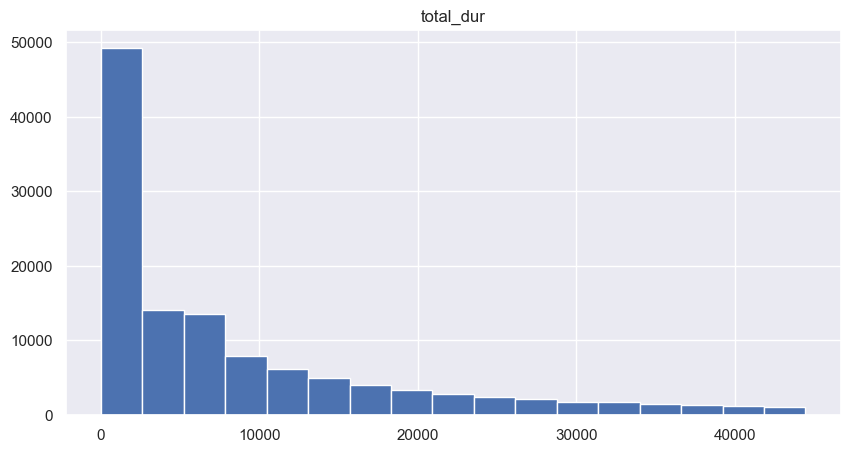

In [137]:
group_A = users_total_dur_group[users_total_dur_group.group == 'A']
n = int(1 + np.log2(group_A['total_dur'].shape[0]) // 1)
group_A.hist(bins=n, figsize=(10 ,5))

array([[<Axes: title={'center': 'total_dur'}>]], dtype=object)

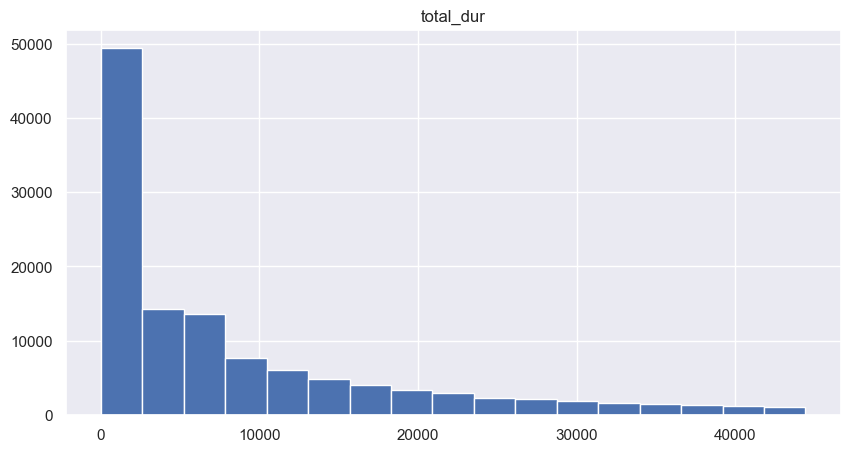

In [138]:
group_B = users_total_dur_group[users_total_dur_group.group == 'B']
n = int(1 + np.log2(group_B['total_dur'].shape[0]) // 1)
group_B.hist(bins=n, figsize=(10 ,5))

* Разбиение с перемешиванием

In [139]:
group_A, group_B = train_test_split(users_total_dur, test_size=0.5, shuffle=True)
group_A['group'] = 'A'
group_B['group'] = 'B'

In [140]:
pd.concat([group_A, group_B]).groupby(by='group', as_index=False).count()

,group,user_id,total_dur
0,A,118853,118853
1,B,118853,118853


array([[<Axes: title={'center': 'total_dur'}>]], dtype=object)

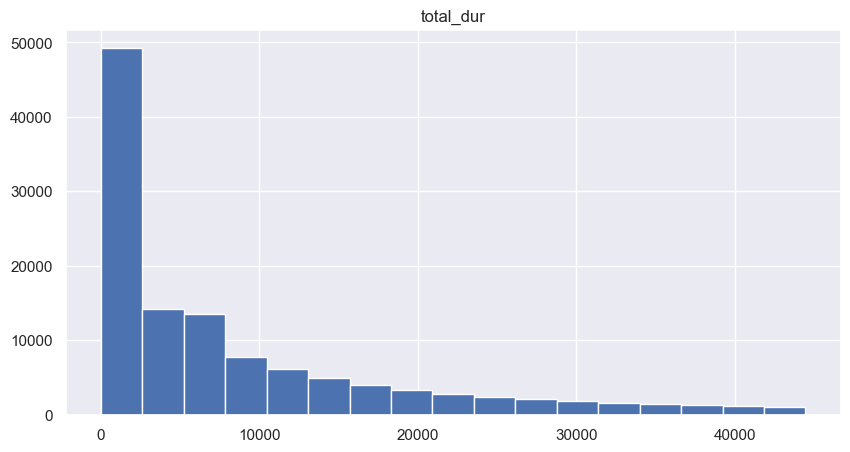

In [141]:
n = int(1 + np.log2(group_A['total_dur'].shape[0]) // 1)
group_A.hist(bins=n, figsize=(10 ,5))

array([[<Axes: title={'center': 'total_dur'}>]], dtype=object)

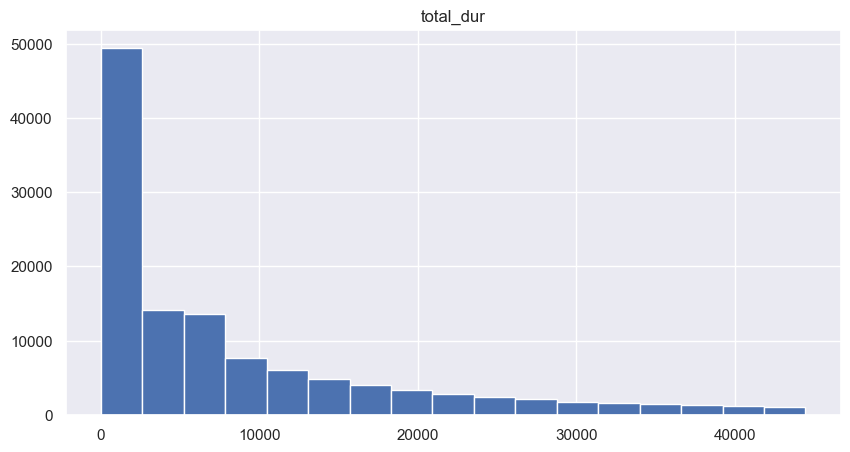

In [142]:
n = int(1 + np.log2(group_B['total_dur'].shape[0]) // 1)
group_B.hist(bins=n, figsize=(10 ,5))

📝 Оценим скорость исполнения \
Оценим скорость исполнения каждого метода разбиения на группы. Из эксперимента видно, что метод соль + хеширование занимает больше времени, чем разбиение с перемешиванием. У нас нет проблемы воспроизводимости данные (нет необходимости или можно сохранять логи), поэтому в следующих экспериментах будет использоваться второй метод.

In [143]:
%%time
_ = groups_splitter(users_total_dur,
                    columns=['user_id', 'total_dur', 'group'])

CPU times: total: 46.9 ms
Wall time: 447 ms


In [144]:
%%time
_ = train_test_split(users_total_dur, 
                     test_size=0.5, 
                     shuffle=True)

CPU times: total: 31.2 ms
Wall time: 27.2 ms


📝 Стратифицированное разбиение
<p>Опыт показывает, что применение стратификации к большим выборкам, вместо рандомного разбиения, не дает большого прироста в качестве A/B-тестирования.</p>
<p>Можно было бы в этом убедиться визуально по графикам. Однако, как упоминалось ранее, в данных присутствует ошибка. При попытке смержить таблицу users с таблицей users_total_dur размер итоговой таблицы меньше размера таблицы users_total_dur. В общем случае теряем 50к данных пользователей.</p>
<p>То есть, если бы не теряли в данных и применяли стратификацию для разбиения на группы, можно было бы ожидать более качественное разбиение. В нашем случае визуальный анализ теряей всякий смысл.</p>

In [145]:
users_total_dur

,user_id,total_dur
0,1,21172
1,1000,10744
2,1000000,32990
3,1000001,52
4,1000003,625
...,...,...
266076,999978,11172
266077,999987,27888
266078,999989,4563
266079,999990,997


In [146]:
users_total_dur.merge(users, how='inner', on=['user_id'])

,user_id,total_dur,age,income,sex,kids_flg
0,1,21172,age_25_34,income_20_40,Ж,1
1,1000,10744,age_45_54,income_20_40,М,0
2,1000001,52,age_45_54,income_20_40,Ж,0
3,1000008,3691,age_25_34,income_40_60,Ж,1
4,1000013,2430,age_35_44,income_40_60,Ж,0
...,...,...,...,...,...,...
187088,99997,30672,age_35_44,income_40_60,Ж,0
187089,999977,4570,age_35_44,income_20_40,Ж,1
187090,999978,11172,age_18_24,income_20_40,Ж,0
187091,999987,27888,age_35_44,income_20_40,М,0


##### Выбор критерия

Возможные критерии:
- параметрические критерии
    - Z-test для разности средних
    - T-test для разности средних
    - Хи-квадрат для разности дисперсий
    - F-критерий для отношения дисперсий
- непараметрические критерии
    - U-критерий Манна-Уитни
    - Критерий Колмогорова-Смирнова
- бутстреп

Метрика нами определена ранее - это TVTu.

Далее рассмотрим следующие сочитания метрика + критерий:
- TVTu + бутстреп
- логарифмированная TVTu + бутстреп
- TVTu + манна-уитни
- логарифмированная TVTu + манна-уитни
- TVTu + t-test
- логарифмированная TVTu + t-test

# Дизайн A/B: TVTu + бутстреп

##### A/A-тест

Корректность:

In [147]:
correctness = []
values = []

for i in tqdm(range(1000)):
    group_A, group_B = train_test_split(users_total_dur, 
                                        test_size=0.5, 
                                        shuffle=True)
    #bootstrap
    sample_a_mean = calc_bootstrap_mean(group_A['total_dur'], size=250)
    sample_b_mean = calc_bootstrap_mean(group_B['total_dur'], size=250)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    correctness.append(not left_side <= 0 <= right_side)
    test_correctness = collections.Counter(correctness)

print(f'Корректность: {1 - test_correctness[1]/(test_correctness[1] + test_correctness[0])}')

100%|██████████| 1000/1000 [06:46<00:00,  2.46it/s]

Корректность: 0.933


Оценка равномерности распределения p-value:

In [148]:
pvalues = [get_p_value(dist) for dist in values]

In [149]:
stat, p_value = kstest(pvalues, uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.04811098765192623 - p_values неравномерное распределение


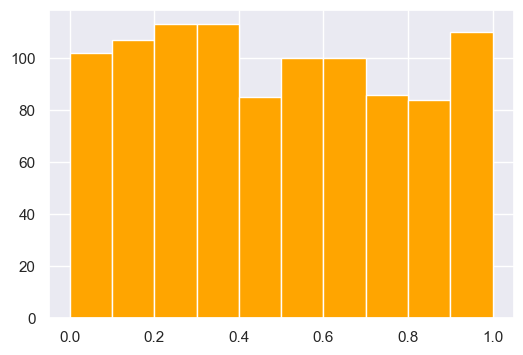

In [150]:
plot_pvalues_hist(pvalues)

##### A/B-тест

In [151]:
# Эффект 1%

power = []
values = []

for i in tqdm(range(1000)):
    group_A, group_B = train_test_split(users_total_dur, 
                                        test_size=0.5, 
                                        shuffle=True)

    group_B['total_dur_1_eff'] = group_B['total_dur'] * (1 + 0.01)

    #bootstrap 1%
    sample_a_mean = calc_bootstrap_mean(group_A['total_dur'], size=250)
    sample_b_mean = calc_bootstrap_mean(group_B['total_dur_1_eff'], size=250)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                          [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    power.append(not left_side <= 0 <= right_side)

    test_power = collections.Counter(power)

print(f'Мощность: {test_power[1]/(test_power[1] + test_power[0])}')

100%|██████████| 1000/1000 [06:35<00:00,  2.53it/s]

Мощность: 0.527


In [152]:
# Эффект 3%

power = []
values = []

for i in tqdm(range(1000)):
    group_A, group_B = train_test_split(users_total_dur, 
                                        test_size=0.5, 
                                        shuffle=True)

    group_B['total_dur_3_eff'] = group_B['total_dur'] * (1 + 0.03)

    #bootstrap 3%
    sample_a_mean = calc_bootstrap_mean(group_A['total_dur'], size=250)
    sample_b_mean = calc_bootstrap_mean(group_B['total_dur_3_eff'], size=250)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                          [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    power.append(not left_side <= 0 <= right_side)

    test_power = collections.Counter(power)

print(f'Мощность: {test_power[1]/(test_power[1] + test_power[0])}')

100%|██████████| 1000/1000 [06:32<00:00,  2.55it/s]

Мощность: 1.0


In [24]:
# Эффект 5%

power = []
values = []

for i in tqdm(range(1000)):
    group_A, group_B = train_test_split(users_total_dur, 
                                        test_size=0.5, 
                                        shuffle=True)

    group_B['total_dur_5_eff'] = group_B['total_dur'] * (1 + 0.05)

    #bootstrap 5%
    sample_a_mean = calc_bootstrap_mean(group_A['total_dur'], size=250)
    sample_b_mean = calc_bootstrap_mean(group_B['total_dur_5_eff'], size=250)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                          [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    power.append(not left_side <= 0 <= right_side)

    test_power = collections.Counter(power)

print(f'Мощность: {test_power[1]/(test_power[1] + test_power[0])}')

100%|██████████| 1000/1000 [07:26<00:00,  2.24it/s]

Мощность: 1.0


**Вывод:**
1. A/A тест: Высокая корректность (0.933) и равномерное распределение p-values указывают на то, что тест работает правильно и не имеет систематических ошибок. Это хороший знак, подтверждающий надежность метода. \
    На семинаре была получена корректность (0.98), что незначительно больше полученного результата.

2. A/B тест:

   • Мощность 0.527 для 1% эффекта говорит о том, что вероятность обнаружения такого небольшого эффекта низка, что может быть проблемой, если необходимо выявить минимальные изменения.

   • Мощность 1.0 для 3% и 5% эффектов показывает, что тест способен эффективно обнаруживать более значительные изменения.

**Итог:** \
Возможно стоит увеличить размеры подвыборок в бутстреп, чтобы получить точные (несмещенные) оценки мат.ожидания. Также можно рассмотреть увеличение размера выборки или изменение дизайна эксперимента для улучшения чувствительности к меньшим эффектам.

# Дизайн A/B: лог.TVTu + бутстреп

In [154]:
users_total_dur['total_dur_ln'] = np.log2(users_total_dur['total_dur'])

##### A/A-тест

Корректность:

In [155]:
correctness = []
values = []

for i in tqdm(range(1000)):
    group_A, group_B = train_test_split(users_total_dur, 
                                        test_size=0.5, 
                                        shuffle=True)
    #bootstrap
    sample_a_mean = calc_bootstrap_mean(group_A['total_dur_ln'], size=250)
    sample_b_mean = calc_bootstrap_mean(group_B['total_dur_ln'], size=250)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                          [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    correctness.append(not left_side <= 0 <= right_side)
    test_correctness = collections.Counter(correctness)

print(f'Корректность: {1 - test_correctness[1]/(test_correctness[1] + test_correctness[0])}')

100%|██████████| 1000/1000 [06:24<00:00,  2.60it/s]

Корректность: 0.951


Оценка равномерности распределения p-value:

In [156]:
pvalues = [get_p_value(dist) for dist in values]

In [157]:
stat, p_value = kstest(pvalues, uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.28580600094044617 - p_values равномерное распределение


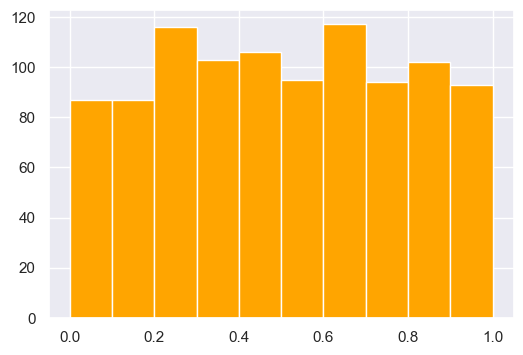

In [158]:
plot_pvalues_hist(pvalues)

##### A/B-тест

In [159]:
# Эффект 1%

power = []
values = []

for i in tqdm(range(1000)):
    group_A, group_B = train_test_split(users_total_dur, 
                                        test_size=0.5, 
                                        shuffle=True)

    group_B['total_dur_ln_1_eff'] = np.log2(group_B['total_dur'] * (1 + 0.01))

    #bootstrap 1%
    sample_a_mean = calc_bootstrap_mean(group_A['total_dur_ln'], size=250)
    sample_b_mean = calc_bootstrap_mean(group_B['total_dur_ln_1_eff'], size=250)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                          [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    power.append(not left_side <= 0 <= right_side)

    test_power = collections.Counter(power)

print(f'Мощность: {test_power[1]/(test_power[1] + test_power[0])}')


100%|██████████| 1000/1000 [06:29<00:00,  2.57it/s]

Мощность: 0.185


In [160]:
# Эффект 3%

power = []
values = []

for i in tqdm(range(1000)):
    group_A, group_B = train_test_split(users_total_dur, 
                                        test_size=0.5, 
                                        shuffle=True)

    group_B['total_dur_ln_3_eff'] = np.log2(group_B['total_dur'] * (1 + 0.03))

    #bootstrap 3%
    sample_a_mean = calc_bootstrap_mean(group_A['total_dur_ln'], size=250)
    sample_b_mean = calc_bootstrap_mean(group_B['total_dur_ln_3_eff'], size=250)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                          [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    power.append(not left_side <= 0 <= right_side)

    test_power = collections.Counter(power)

print(f'Мощность: {test_power[1]/(test_power[1] + test_power[0])}')

100%|██████████| 1000/1000 [06:28<00:00,  2.58it/s]

Мощность: 0.876


In [161]:
# Эффект 5%

power = []
values = []

for i in tqdm(range(1000)):
    group_A, group_B = train_test_split(users_total_dur, 
                                        test_size=0.5, 
                                        shuffle=True)

    group_B['total_dur_ln_5_eff'] = np.log2(group_B['total_dur'] * (1 + 0.05))

    #bootstrap 5%
    sample_a_mean = calc_bootstrap_mean(group_A['total_dur_ln'], size=250)
    sample_b_mean = calc_bootstrap_mean(group_B['total_dur_ln_5_eff'], size=250)
    values.append(sample_a_mean - sample_b_mean)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                          [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

    power.append(not left_side <= 0 <= right_side)

    test_power = collections.Counter(power)

print(f'Мощность: {test_power[1]/(test_power[1] + test_power[0])}')

100%|██████████| 1000/1000 [06:29<00:00,  2.57it/s]

Мощность: 0.998


**Вывод:**
1. A/A тест:

   • Корректность 0.951 указывает на то, что тест имеет высокую вероятность правильно идентифицировать отсутствие эффекта, что говорит о хорошей настройке и надежности теста.

   • Равномерное распределение p-values свидетельствует о том, что нет систематических ошибок в тестировании.

2. A/B тест:
   • Мощность теста при 1% эффекта (0.185) достаточно низкая, что означает, что тест с большой вероятностью не сможет обнаружить такой малый эффект.

   • Мощность при 3% (0.876) уже значительно выше, что говорит о том, что тест сможет обнаружить этот эффект с высокой вероятностью.

   • Мощность при 5% (0.998) практически максимальна, что указывает на то, что тест с высокой уверенностью сможет выявить такой эффект.

**Итог:**\
Логарифмирование метрики, хотя и улучшает корректность A/A теста, снижает мощность A/B теста для обнаружения малых эффектов (1%). Возможно стоит увеличить размеры подвыборок в бутстреп, чтобы получить точные (несмещенные) оценки мат.ожидания.


# Дизайн A/B: TVTu + манна-уитни

##### A/A-тест

Корректность:

In [162]:
pvalues = []
for i in tqdm(range(1000)):
  group_A, group_B = train_test_split(users_total_dur, 
                                      test_size=0.5, 
                                      shuffle=True)
  u, p = mannwhitneyu(
        group_A['total_dur'].values,
        group_B['total_dur'].values
    )
  pvalues.append(p)

pvalues = np.array(pvalues)
print(f"Корректность = {1 - pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0]:.3f}")

100%|██████████| 1000/1000 [00:37<00:00, 26.78it/s]

Корректность = 0.946


Оценка равномерности распределения p-value:

In [163]:
stat, p_value = kstest(pvalues, uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.9089904277834007 - p_values равномерное распределение


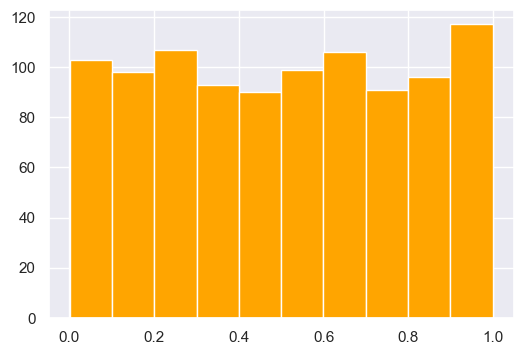

In [164]:
plot_pvalues_hist(pvalues)

##### A/B-тест

In [165]:
pvalues_1_eff = []
pvalues_3_eff = []
pvalues_5_eff = []

for i in tqdm(range(1000)):
  group_A, group_B = train_test_split(users_total_dur, 
                                      test_size=0.5, 
                                      shuffle=True)
  group_B['total_dur_1_eff'] = group_B['total_dur'] * (1 + 0.01)
  group_B['total_dur_3_eff'] = group_B['total_dur'] * (1 + 0.03)
  group_B['total_dur_5_eff'] = group_B['total_dur'] * (1 + 0.05)
  
  u, p = mannwhitneyu(group_A['total_dur'].values, group_B['total_dur_1_eff'].values)
  pvalues_1_eff.append(p)
  u, p = mannwhitneyu(group_A['total_dur'].values, group_B['total_dur_3_eff'].values)
  pvalues_3_eff.append(p)
  u, p = mannwhitneyu(group_A['total_dur'].values, group_B['total_dur_5_eff'].values)
  pvalues_5_eff.append(p)

pvalues_1_eff = np.array(pvalues_1_eff)
pvalues_3_eff = np.array(pvalues_3_eff)
pvalues_5_eff = np.array(pvalues_5_eff)

print(f"Мощность (эффект 1%) = {pvalues_1_eff[pvalues_1_eff < 0.05].shape[0] / pvalues_1_eff.shape[0]}")
print(f"Мощность (эффект 3%) = {pvalues_3_eff[pvalues_3_eff < 0.05].shape[0] / pvalues_3_eff.shape[0]}")
print(f"Мощность (эффект 5%) = {pvalues_5_eff[pvalues_5_eff < 0.05].shape[0] / pvalues_5_eff.shape[0]}")

100%|██████████| 1000/1000 [01:09<00:00, 14.32it/s]

Мощность (эффект 1%) = 0.283
Мощность (эффект 3%) = 0.978
Мощность (эффект 5%) = 1.0


**Вывод:**
1. A/A тест:

   • Корректность (0.946) указывает на то, что тест имеет высокую вероятность правильно идентифицировать отсутствие эффекта, что говорит о хорошей настройке и надежности теста.

   • Равномерное распределение p-values свидетельствует о том, что нет систематических ошибок в тестировании.

2. A/B тест:

   • Мощность 0.283 для 1% эффекта говорит о том, что вероятность обнаружить такой небольшой эффект довольно низка.

   • Мощность 0.978 для 3% эффекта и 1.0 для 5% эффекта свидетельствует о том, что более крупные эффекты легко обнаруживаются.

**Итог:**\
В общем, тест имеет хорошую способность выявлять значимые различия при более выраженных эффектах (3% и выше), но может не быть достаточно мощным для обнаружения небольших изменений (1%).

# Дизайн A/B: лог.TVTu + манна-уитни

In [ ]:
users_total_dur['total_dur_ln'] = np.log2(users_total_dur['total_dur'])

##### A/A-тест

Корректность:

In [167]:
pvalues = []
for i in tqdm(range(1000)):
  group_A, group_B = train_test_split(users_total_dur, 
                                      test_size=0.5, 
                                      shuffle=True)
  u, p = mannwhitneyu(
        group_A['total_dur_ln'].values,
        group_B['total_dur_ln'].values
    )
  pvalues.append(p)

pvalues = np.array(pvalues)
print(f"Корректность = {1 - pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0]:.3f}")

100%|██████████| 1000/1000 [00:34<00:00, 29.13it/s]

Корректность = 0.953


Оценка равномерности распределения p-value

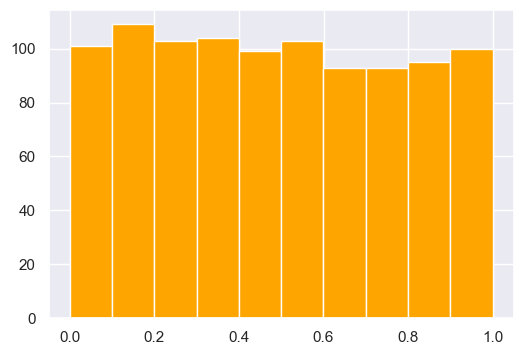

In [168]:
plot_pvalues_hist(pvalues)

In [169]:
stat, p_value = kstest(pvalues, uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.7004107094503211 - p_values равномерное распределение


##### A/B-тест

In [170]:
pvalues_1_eff = []
pvalues_3_eff = []
pvalues_5_eff = []

for i in tqdm(range(1000)):
  group_A, group_B = train_test_split(users_total_dur, 
                                      test_size=0.5, 
                                      shuffle=True)
  group_B['total_dur_ln_1_eff'] = np.log2(group_B['total_dur'] * (1 + 0.01))
  group_B['total_dur_ln_3_eff'] = np.log2(group_B['total_dur'] * (1 + 0.03))
  group_B['total_dur_ln_5_eff'] = np.log2(group_B['total_dur'] * (1 + 0.05))
  
  u, p = mannwhitneyu(group_A['total_dur_ln'].values, group_B['total_dur_ln_1_eff'].values)
  pvalues_1_eff.append(p)
  u, p = mannwhitneyu(group_A['total_dur_ln'].values, group_B['total_dur_ln_3_eff'].values)
  pvalues_3_eff.append(p)
  u, p = mannwhitneyu(group_A['total_dur_ln'].values, group_B['total_dur_ln_5_eff'].values)
  pvalues_5_eff.append(p)

pvalues_1_eff = np.array(pvalues_1_eff)
pvalues_3_eff = np.array(pvalues_3_eff)
pvalues_5_eff = np.array(pvalues_5_eff)

print(f"Мощность (эффект 1%) = {pvalues_1_eff[pvalues_1_eff < 0.05].shape[0] / pvalues_1_eff.shape[0]}")
print(f"Мощность (эффект 3%) = {pvalues_3_eff[pvalues_3_eff < 0.05].shape[0] / pvalues_3_eff.shape[0]}")
print(f"Мощность (эффект 5%) = {pvalues_5_eff[pvalues_5_eff < 0.05].shape[0] / pvalues_5_eff.shape[0]}")

100%|██████████| 1000/1000 [01:12<00:00, 13.83it/s]

Мощность (эффект 1%) = 0.277
Мощность (эффект 3%) = 0.977
Мощность (эффект 5%) = 1.0


**Выводы:**

1. A/A тест: 
    
    • Высокая корректность (0.953) и равномерное распределение p-values указывают на то, что тест был проведен корректно, и нет явных искажений в данных.

2. A/B тест: Мощность теста показывает, что:

   • Для выявления 1% эффекта мощность составляет лишь 0.277, что говорит о низкой вероятности обнаружения такого небольшого эффекта.

   • Для 3% эффекта мощность значительно возрастает до 0.977, что означает, что вы с высокой вероятностью сможете обнаружить этот эффект.

   • Для 5% эффекта мощность достигает 1.0, что указывает на уверенность в обнаружении этого эффекта.

**Итог:**\
 A/B тест имеет высокую мощность для обнаружения эффектов размером 3% и более, но низкую мощность для обнаружения малых эффектов (1%). Это может ограничивать способность выявлять незначительные изменения в метриках.

# Дизайн A/B: TVTu + t-test

##### A/A-тест

Корректность:

In [171]:
pvalues = []

for i in tqdm(range(1000)):
  group_A, group_B = train_test_split(users_total_dur, 
                                      test_size=0.5, 
                                      shuffle=True)
  p = ttest_ind(group_A['total_dur'].values, 
                group_B['total_dur'].values, 
                equal_var=False).pvalue
  pvalues.append(p)

pvalues = np.array(pvalues)
print(f"Корректность = {1 - pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0]:.3f}")

100%|██████████| 1000/1000 [00:23<00:00, 42.40it/s]

Корректность = 0.958


Оценка равномерности распределения p-value

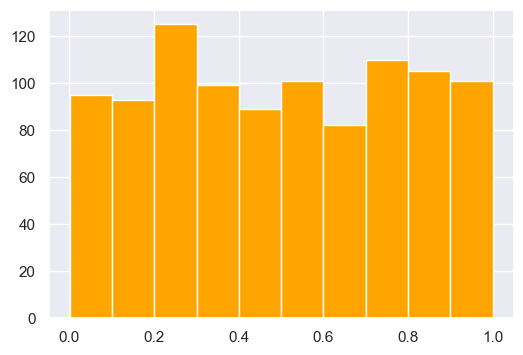

In [172]:
plot_pvalues_hist(pvalues)

In [173]:
stat, p_value = kstest(pvalues, uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.8650217151487174 - p_values равномерное распределение


##### A/B-тест

In [174]:
pvalues_1_eff = []
pvalues_3_eff = []
pvalues_5_eff = []

for i in tqdm(range(1000)):
  group_A, group_B = train_test_split(users_total_dur, 
                                      test_size=0.5, 
                                      shuffle=True)
  group_B['total_dur_1_eff'] = group_B['total_dur'] * (1 + 0.01)
  group_B['total_dur_3_eff'] = group_B['total_dur'] * (1 + 0.03)
  group_B['total_dur_5_eff'] = group_B['total_dur'] * (1 + 0.05)
  
  stat, p = ttest_ind(group_A['total_dur'].values, 
                          group_B['total_dur_1_eff'].values, 
                          equal_var=False)
  pvalues_1_eff.append(p)
  stat, p = ttest_ind(group_A['total_dur'].values, 
                          group_B['total_dur_3_eff'].values, 
                          equal_var=False)
  pvalues_3_eff.append(p)
  stat, p = ttest_ind(group_A['total_dur'].values, 
                          group_B['total_dur_5_eff'].values, 
                          equal_var=False)
  pvalues_5_eff.append(p)

pvalues_1_eff = np.array(pvalues_1_eff)
pvalues_3_eff = np.array(pvalues_3_eff)
pvalues_5_eff = np.array(pvalues_5_eff)

print(f"Мощность (эффект 1%) = {pvalues_1_eff[pvalues_1_eff < 0.05].shape[0] / pvalues_1_eff.shape[0]}")
print(f"Мощность (эффект 3%) = {pvalues_3_eff[pvalues_3_eff < 0.05].shape[0] / pvalues_3_eff.shape[0]}")
print(f"Мощность (эффект 5%) = {pvalues_5_eff[pvalues_5_eff < 0.05].shape[0] / pvalues_5_eff.shape[0]}")

100%|██████████| 1000/1000 [00:28<00:00, 34.66it/s]

Мощность (эффект 1%) = 0.511
Мощность (эффект 3%) = 1.0
Мощность (эффект 5%) = 1.0


**Выводы:**

1. A/A тест:

   • Корректность 0.958 указывает на то, что тест работает корректно, и вероятность ложноположительных результатов низка.

   • Равномерное распределение p-values говорит о том, что нет систематических смещений в данных.

2. A/B тест:

   • Мощность 0.511 при 1% эффекта указывает на то, что вероятность обнаружить такой небольшой эффект достаточно низка. Это означает, что тест может не быть чувствительным к небольшим изменениям.

   • Мощность 1.0 при 3% и 5% эффекта показывает, что тест способен надежно обнаруживать более значительные изменения.

**Итог:**\
A/B тест имеет хорошую мощность для обнаружения эффектов в 3% и 5%, но недостаточную мощность для выявления небольших изменений в 1%. Это может указывать на необходимость увеличения размера выборки или пересмотра дизайна эксперимента для более чувствительного обнаружения малых эффектов.

# Дизайн A/B: лог.TVTu + t-test

In [175]:
users_total_dur['total_dur_ln'] = np.log2(users_total_dur['total_dur'])

##### A/A-тест

Корректность:

In [176]:
pvalues = []

for i in tqdm(range(1000)):
  group_A, group_B = train_test_split(users_total_dur, 
                                      test_size=0.5, 
                                      shuffle=True)
  p = ttest_ind(group_A['total_dur_ln'].values, 
                group_B['total_dur_ln'].values, 
                equal_var=False).pvalue
  pvalues.append(p)

pvalues = np.array(pvalues)
print(f"Корректность = {1 - pvalues[pvalues < 0.05].shape[0] / pvalues.shape[0]:.3f}")

100%|██████████| 1000/1000 [00:23<00:00, 42.64it/s]

Корректность = 0.954


Оценка равномерности распределения p-value

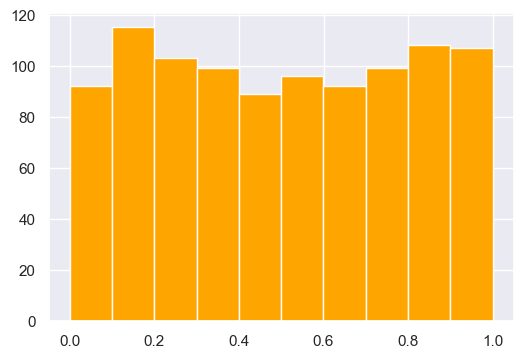

In [177]:
plot_pvalues_hist(pvalues)

In [178]:
stat, p_value = kstest(pvalues, uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.5996735804955592 - p_values равномерное распределение


##### A/B-тест

In [179]:
pvalues_1_eff = []
pvalues_3_eff = []
pvalues_5_eff = []

for i in tqdm(range(1000)):
  group_A, group_B = train_test_split(users_total_dur, 
                                      test_size=0.5, 
                                      shuffle=True)
  group_B['total_dur_ln_1_eff'] = np.log2(group_B['total_dur'] * (1 + 0.01))
  group_B['total_dur_ln_3_eff'] = np.log2(group_B['total_dur'] * (1 + 0.03))
  group_B['total_dur_ln_5_eff'] = np.log2(group_B['total_dur'] * (1 + 0.05))
  
  stat, p = ttest_ind(group_A['total_dur_ln'].values, 
                group_B['total_dur_ln_1_eff'].values, 
                equal_var=False)
  pvalues_1_eff.append(p)
  stat, p = ttest_ind(group_A['total_dur_ln'].values, 
                group_B['total_dur_ln_3_eff'].values, 
                equal_var=False)
  pvalues_3_eff.append(p)
  stat, p = ttest_ind(group_A['total_dur_ln'].values, 
                group_B['total_dur_ln_5_eff'].values, 
                equal_var=False)
  pvalues_5_eff.append(p)

pvalues_1_eff = np.array(pvalues_1_eff)
pvalues_3_eff = np.array(pvalues_3_eff)
pvalues_5_eff = np.array(pvalues_5_eff)

print(f"Мощность (эффект 1%) = {pvalues_1_eff[pvalues_1_eff < 0.05].shape[0] / pvalues_1_eff.shape[0]}")
print(f"Мощность (эффект 3%) = {pvalues_3_eff[pvalues_3_eff < 0.05].shape[0] / pvalues_3_eff.shape[0]}")
print(f"Мощность (эффект 5%) = {pvalues_5_eff[pvalues_5_eff < 0.05].shape[0] / pvalues_5_eff.shape[0]}")

100%|██████████| 1000/1000 [00:29<00:00, 33.72it/s]

Мощность (эффект 1%) = 0.174
Мощность (эффект 3%) = 0.873
Мощность (эффект 5%) = 1.0


Ваши результаты A/B тестирования показывают следующее:

1. A/A тест: 

   • Высокая корректность (0.954) и равномерное распределение p-values указывают на то, что тест был проведен корректно и не содержит систематических ошибок.

2. A/B тест:

   • Мощность для 1% эффекта (0.174) значительно ниже, что говорит о том, что тест имеет низкую вероятность обнаружить такой малый эффект.

   • Мощность для 3% эффекта (0.873) уже выше, но все еще не идеальна, что может быть проблемой, если необходимо обнаружить небольшие изменения.

   • Мощность для 5% эффекта (1.0) указывает на то, что тест способен надежно обнаруживать такие изменения.

Вывод: \
Использование t-test без логарифмирования метрики обеспечивает более высокую мощность для обнаружения малых эффектов, что делает его предпочтительным выбором для A/B тестирования.

# A/B-тест

Результаты экспериментов показали незначительную разницу корректности (все >0.9) и мощности (все отлавливают эффект 3% и 5%) между тестами.

Выбор подходящего метода для A/B-тестирования зависит от характеристик данных и целей анализа. Поскольку данные распределены ненормально и напоминают экспоненциальное распределение, это важно учитывать при выборе статистического теста. 

С учетом ненормального распределения данных, лучшими вариантами будут:

• Бутстреп (TVTu или логарифмированная TVTu)

• Манна-Уитни (TVTu или логарифмированная TVTu)

Чтобы улучшить нормальность данных, можно использовать логарифмирование и затем применять бутстреп или Манна-Уитни.

Пара TVTu + бутстреп показал лучше результаты, чем остальные, поэтому выбор был сделан в пользу пары TVTu + бутстреп.

In [115]:
# Занулите для всех пользователей total_dur, у которых total_dur < 500
users_total_dur['total_dur'][users_total_dur['total_dur'] < 500] = 0

C:\Users\kshch\AppData\Local\Temp\ipykernel_37216\405984320.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  users_total_dur['total_dur'][users_total_dur['total_dur'] < 500] = 0


In [116]:
users_total_dur

,user_id,total_dur
0,1,21172
1,1000,10744
2,1000000,32990
3,1000001,0
4,1000003,625
...,...,...
266076,999978,11172
266077,999987,27888
266078,999989,4563
266079,999990,997


In [117]:
# Разбейте их самостоятельно на две равные группы
users_total_dur_group = groups_splitter(users_total_dur, 
                                        columns=['user_id', 'total_dur', 'group'],
                                        user_salt='kiontestmodel20210805')
users_total_dur_group.groupby(by='group', as_index=False).count()

,group,user_id,total_dur
0,A,119355,119355
1,B,118351,118351


In [118]:
group_A = users_total_dur_group[users_total_dur_group.group == 'A']
group_B = users_total_dur_group[users_total_dur_group.group == 'B']

Примем за самых смотрящих пользователей тех, у кого `total_dur > 10 000`

<Axes: >

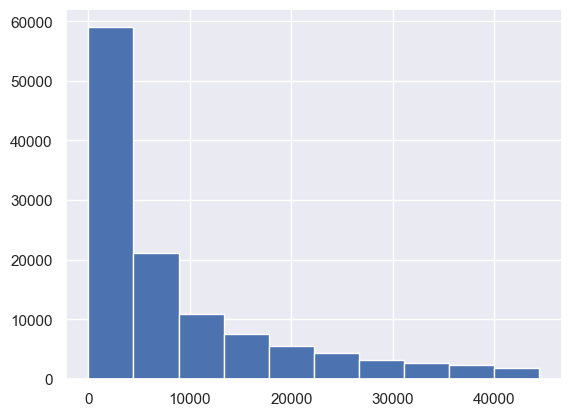

In [120]:
group_B['total_dur'].hist()

In [121]:
# докидываем эффект 2.5% на 10% самых смотрящих пользователей
index = group_B[group_B['total_dur'] > 10000].sample(frac=0.1).index
group_B.loc[index]['total_dur'] = group_B.loc[index]['total_dur'] * (1 + 0.025)

In [122]:
# A/B-тест

sample_a_mean = calc_bootstrap_mean(group_A['total_dur'], size=1000)
sample_b_mean = calc_bootstrap_mean(group_B['total_dur'], size=1000)

left_side, right_side = np.percentile(sample_a_mean - sample_b_mean,
                                        [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

if left_side <= 0 <= right_side:
    print(f'Эффект не отловлен')
else:
    print(f'Эффект отловлен')

Эффект не отловлен


**Выводы:**\
Поскольку доверительный интервал включает отрицательные значения, это указывает на то, что разница в результатах может быть статистически незначимой. Следовательно, нельзя однозначно утверждать, что модель в группе В лучше, чем в группе А, и требуется дополнительный анализ для более точных выводов.